In [ ]:
from collections import Counter
import numpy as np
import torch
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# prepare text using the spacy english pipeline (see https://spacy.io/models/en)
# we'll use it to lemmatize the text, and determine which part of speech each
# lemmatize edits words to become the 'root' word - e.g. holds -> hold;  rubs->rub
# part of speech indicates if the item is a verb, nooun, punctuation, space and so on.
# make sure that the text sent to spacy doesn't end with a period immediately followed by a newline,
# instead, make sure there is a space between the period and the newline, so that the period 
# is correctly identified as punctuation.

def prepare_texts(text):    
    # Get a callable object from spaCy that processes the text - lemmatizes and determines part of speech

    nlp = spacy.load("en_core_web_sm")
    
    # lemmatize the text, get part of speech, and remove spaces and punctuation
    
    lemmas = [tok.lemma_ for tok in nlp(text) if tok.pos_ not in ["PUNCT", "SPACE"]]
    
    # count the number of occurences of each word in the vocabulary
    
    freqs = Counter() 
    for w in lemmas:
        freqs[w] += 1
        
    vocab = list(freqs.items())  # List of (word, occurrence)
    
    vocab = sorted(vocab, key=lambda item: item[1], reverse=True)  # Sort by decreasing frequency
    print(vocab)
    
    # Create word->index dictionary and index->word dictionary
    
    v2i = {v[0]:i for i,v in enumerate(vocab)}
    i2v = {i:v[0] for i,v in enumerate(vocab)}
    
    return lemmas, v2i, i2v

In [ ]:
fileObject = open("SmallSimpleCorpus.txt", "r")
data = fileObject.read()
print(data)

I hold a dog.  I hold the dog.  I hold a cat.  I hold the cat.  I rub a dog.  I rub the dog.  I rub a cat.  I rub the cat.  I hold and rub a dog.  I hold and rub the dog.  I hold and rub a cat.  I hold and rub the cat.  I hold a dog and cat.  I hold the dog and cat.  I hold a cat and dog.  I hold the cat and dog.  I rub a dog and cat.  I rub the dog and cat.  I rub a cat and dog.  I rub the cat and dog.  I hold and rub a dog .  I hold and rub a cat.  I hold and rub the dog.  I hold and rub the cat .  I can hold a dog.  I can hold the dog.  I can hold a cat.  I can hold the cat.  I can rub a dog.  I can rub the dog.  I can rub a cat.  I can rub the cat.  I can hold a dog and cat.  I can hold the dog and cat.  I can hold a cat and dog.  I can hold the cat and dog.  I can hold and rub a dog.  I can hold and rub the dog.  I can hold and rub a cat.  I can hold and rub the cat.  I can rub a dog and cat.  I can rub the dog and cat.  I can rub a cat and dog.  I can rub the cat and dog.  I can 

In [ ]:
lemmas, v2i, i2v= prepare_texts(data)

[('and', 160), ('hold', 128), ('dog', 128), ('cat', 128), ('rub', 128), ('a', 104), ('the', 104), ('can', 104), ('she', 96), ('he', 96), ('I', 80)]


#### This following function walks through each word, and looks at a window (of size 'window') of words and creates input/output prediction pairs, predicting each of the words surrounding the current word from the current word.  So here we say that we are 'predicting the context' from the word

In [ ]:
lemmas = []
for line in data.split('.  '):
  temp1, temp2, temp3 = prepare_texts(line)
  lemmas.append(temp1)

In [ ]:
def tokenize_and_preprocess_text(textlist, v2i, window):

    # Predict context with word. Sample the context within a window size.
    X, Y = [], []  # is the list of training/test samples
    
    # TO DO - create all the X,Y pairs
    for word in v2i.keys():
      for line in textlist:
        if word in line:
          if len(line) < window:
            for contxt in line:
              if contxt != word:
                X.append(v2i[word])
                Y.append(v2i[contxt])
          else:
            for i in range(len(line)-window):
              shift_window = line[i:i+window]
              if word in shift_window:
                for contxt in shift_window:
                  if contxt != word:
                    X.append(v2i[word])
                    Y.append(v2i[contxt])
        else:
          continue
    return X, Y

In [ ]:
X, Y= tokenize_and_preprocess_text(lemmas, v2i, 3)

In [ ]:
X[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
Y[0:10]

[10, 1, 1, 4, 4, 5, 10, 1, 1, 4]

## Define Model that will be trained to produce word vectors

In [ ]:
class Word2vecModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        # initialize word vectors to random numbers 
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.fc = torch.nn.Linear(embedding_size, vocab_size)
        
    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        e = self.embedding(x)
        logits = self.fc(e)
        return logits, e

#### The training function - give it the text and it does the rest

In [ ]:
def train_word2vec(textlist, window=3, embedding_size=2):
    # Set up a model with Skip-gram (predict context with word)
    # textlist: a list of the strings
    
    # Create the training data
    X, Y= tokenize_and_preprocess_text(textlist, v2i, window)

    
    # Split the training data
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=1)

    
    # instantiate the network & set up the optimizer
    num_epoch = 50
    learning_rate = 0.001

    loss_func = torch.nn.CrossEntropyLoss()
    network = Word2vecModel(vocab_size=11, embedding_size=embedding_size)
    optimizer = torch.optim.Adam(network.parameters(), lr =learning_rate)

    epoches, train_loss, val_loss = [], [], []
    # training loop
    n = 0
    for epoch in range(num_epoch):
      total_train_loss = 0
      total_val_loss = 0
      for word, target in zip(torch.utils.data.DataLoader(X_train, batch_size=4), torch.utils.data.DataLoader(y_train, batch_size=4)):
        log_prob,embed = network(word)
        loss = loss_func(log_prob, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss+=loss.item()
      
      n += 1
      epoches.append(n)
      total_train_loss/=len(torch.utils.data.DataLoader(X_train, batch_size=4))
      train_loss.append(total_train_loss)

      for word, target in zip(torch.utils.data.DataLoader(X_val, batch_size=4), torch.utils.data.DataLoader(y_val, batch_size=4)):
        log_prob, embed= network(word)
        loss = loss_func(log_prob, target)
        total_val_loss += loss.item()
      total_val_loss/=len(torch.utils.data.DataLoader(X_val, batch_size=4))
      val_loss.append(total_val_loss)
    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()

    return network

### Run Training and retrieve embedding

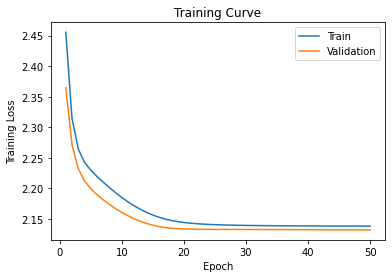

In [ ]:
network = train_word2vec(lemmas)
embedding = network.embedding

In [ ]:
df = pd.DataFrame(embedding.weight.data.detach().numpy(), columns=["X", "Y"])
df['word'] = list(v2i.keys())
df.sort_values(by=['X', 'Y'])

,X,Y,word
0,-0.579545,-0.111654,and
7,-0.444217,-0.241245,can
5,-0.185433,3.124910,a
6,-0.086499,3.227481,the
9,0.792812,0.639501,he
10,0.927650,0.607660,I
8,0.957953,0.651100,she
3,1.072356,-0.816868,cat
2,1.094319,-0.912986,dog
1,1.121425,-0.075383,hold


#### Evaluate some properties of the word embedding

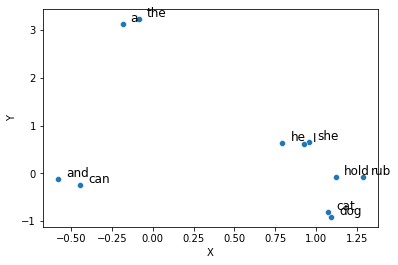

In [ ]:
def visualize_embedding(embedding, most_frequent_from=0, most_frequent_to=40):
    assert embedding.shape[1] == 2, "This only supports visualizing 2-d embeddings!"
    
    df = pd.DataFrame(embedding, columns=['X', 'Y'])
    sns.scatterplot(data=df, x='X', y='Y')
    for i in range(df.shape[0]):
      plt.text(x=df.X[i]+0.05,y=df.Y[i]+0.05,s=list(v2i.keys())[i], fontdict=dict(color='black', size=12))
    
visualize_embedding(embedding.weight.data.detach().numpy(), most_frequent_from=0, most_frequent_to=11)